## Audio Mosaic Generator
## Justin Chen, Nicolas Finkelstein, Kyle LaBrosse
EECS352 -- Professor Pardo

In [2]:
# Import packages
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math, csv
from IPython.display import Audio
from sklearn.datasets import load_iris
import random
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

In [3]:
def plot_audio(x, sr, figsize=(16,4)):
    """
    A simple audio plotting function
    
    Parameters
    ----------
    x: np.ndarray
        Audio signal to plot
    sr: int
        Sample rate
    figsize: tuple
        A duple representing the figure size (xdim,ydim)
    """
    length = float(x.shape[0]) / sr
    t = np.linspace(0,length,x.shape[0])
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.show()

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [5]:
def collect_filenames(path_to_esc50_csv, cat):
    filenames = {cat:[]}
    
    with open(path_to_esc50_csv) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['category'] == cat:
                filenames[cat].append(row['filename'])
                
    
    return filenames

In [6]:
def feature_extraction(signal, sr):
    ## PITCH
    ## CHROMGRAM
    ## COMPARE w/ STFT
    # EXTRACT PITCH and other features
    # 
    mfcc = librosa.feature.mfcc(signal, sr=sr)
    mfcc_mean = []
    mfcc_delta_mean = []
    
    for val in mfcc:
        mfcc_mean.append(np.mean(val))
        mfcc_delta_mean.append(np.mean(np.diff(val)))
    
    mfcc_mean = np.array(mfcc_mean)
    mfcc_delta_mean = np.array(mfcc_delta_mean)
    feature_vector = np.concatenate((mfcc_mean, mfcc_delta_mean))
    return feature_vector

In [7]:
def knn(data_X, data_Y, query_X, dist_measure, k):
    """
    Takes a data set of examples encoded as feature vectors, along with the label for each example in the data. 
    It also takes in a set of queries, for which we want to know the labels. It finds the distance from each 
    query_X to each example in data_X. It returns a label for each example in query_X by picking the most 
    popular label from the k nearest neighbors in data_X. Distance is determined by the selected distance metric.
    
    Input Parameters
    ----------------
    data_X: a 2-D numpy array with a shape of (the number of examples in the data, the number of features).
    data_Y: a 1-D numpy array containing integer labels for the examples in data_X. 
            The labels should be encoded as integer values BEFORE they are passed this function.
            (E.g., [class1, class1, class2, class1] ==> [0, 0, 1, 0])
    query_X: a 2-D numpy array with a shape of (the number of query examples, the number of features). 
            Note, the query_X must have the same number of features, in the same order as the data_X 
    dist_measure: a string determining which distance measure to use. ('euclidean' or 'cosine')
    k: the number of nearest neighbors in the data to consider, when labeling a query
    
    Returns
    ----------------
    query_Y: a 1-D numpy array of integer values referring to predicted labels for the set of queries
    """
    query_Y = []
    
    for i in range(0, np.size(query_X, 0)):
        dic = {}
        for j in range (0, np.size(data_X, 0)):
            label = data_Y[j]
            if label not in dic:
                dic[label] = []
            if dist_measure == 'cosine':
                distance = sp.spatial.distance.cosine(query_X[i], data_X[j])
            elif dist_measure == 'euclidean':
                distance = sp.spatial.distance.euclidean(query_X[i], data_X[j])
            dic[label].append(distance)
            
        for key in dic:
            dic[key].sort()
        
        closest_Labels = []
        
        for i in range (0, k):
            minLabel = None
            minVal = None
            for key in dic:
                if not dic[key]: continue
                if minLabel is None: minLabel = key
                if minVal is None: minVal = dic[key][0]
                if dic[key][0] < minVal:
                    minLabel = key
                    minVal = dic[key][0]
            closest_Labels.append(minLabel)
            dic[minLabel].pop(0)
        
        Kclosest = max(set(closest_Labels), key=closest_Labels.count)
        query_Y.append(Kclosest)
    
    return query_Y

In [8]:
def feature_rescaling(train_X, test_X):
    
    '''

    Input Parameters
    ----------------
    train_X: a 2-D numpy array with a shape of (the number of training examples, the number of features).
    test_X: a 2-D numpy array with a shape of (the number of testing examples, the number of features).
    
    Returns
    ----------------
    train_rescaled_X: the rescaled version of train_X
                    a 2-D numpy array with a shape of (the number of training examples, the number of features).
    test_rescaled_X : the rescaled version of test_X
                    a 2-D numpy array with a shape of (the number of testing examples, the number of features).
    
    '''
    scaler = sklearn.preprocessing.MinMaxScaler()
    
    scaler.fit(train_X)
    
    train_rescaled_X = scaler.transform(train_X)
    test_rescaled_X = scaler.transform(test_X)
           
    return train_rescaled_X, test_rescaled_X

In [9]:
def parse_source_target(index=24, cat="laughing"):
    '''
    Only used if using esc50 data. Index is number in range (0, 40) which contains the index
    of the audio sample we wish to make our target/testing and exclude from training
    '''
    train_filenames = collect_filenames("./esc50/meta/esc50.csv", cat)

    concat = np.array([])
    count = 0
    for key in train_filenames:
        for file in train_filenames[key]:
            if count == index:
                continue
            file = './esc50/audio/' + file
            signal, sr = librosa.load(file, sr=None)
            concat = np.concatenate([concat, signal])
            count += 1

    target = train_filenames[cat][index]
    file = "./esc50/audio/"+target
    target, sr= librosa.load(file, sr=None)
    # target = target[:len(target)//2]
    return concat, target, sr

# Source Selection Here

In [21]:
source, target, sr = parse_source_target(24, "hen")
# source = source[:len(source)]

# source, sr = librosa.load('./audio/sinesweep.wav', sr=None)
# print(sr)
# source = source[len(source)//4:len(source)//2]

# source = source[:len(source)//2]
source, sr = librosa.load('./audio/pianogenie.m4a', sr=None)
# print(sr)
# source = smooth(smooth(source))
target, sr = librosa.load('./audio/pianogenie.m4a', sr=None)
# Audio(target, rate=sr)
# Audio(target, rate=sr)
# target = target[50000:450000]
Audio(source, rate=sr)


In [22]:
# Split source audio
# source = concat

def data_preparation(source, target, window_size=550):
#     source = source[len(source)//2:]
    training = []
    testing = []

    for i in range (0, len(source)-window_size, window_size): #only goes up to half of source
        training.append(feature_extraction(source[i:i+window_size], sr))

    for i in range (0, len(target)-window_size, window_size):
        testing.append(feature_extraction(target[i:i+window_size], sr))
    
    training = np.array(training)
    testing = np.array(testing)
    
    training, testing = feature_rescaling(training, testing)
    label = range(0, len(training)) ## label holds which sample slice index was used
    
    return source, training, label, testing


In [23]:
new_source, training, label, testing = data_preparation(source, target, window_size=1200)

guesses = knn(training, label, testing, 'cosine', 1)

In [24]:
def smoothing(x, window_size, window_type='hann'):
    #preallocate output
    signal = np.array([])
    
    #create window
    if window_type == 'hann':
        w = sp.signal.windows.hann(window_size)
    elif window_type == 'tukey':
        w = sp.signal.windows.tukey(window_size, alpha=.05)
    
    #apply hann window to signal
    num_windows = math.floor(len(x)/window_size)
    for i in range(0, num_windows):
        signal = np.concatenate([signal, x[i*window_size:i*window_size+window_size]*w])
        
    return signal
        


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

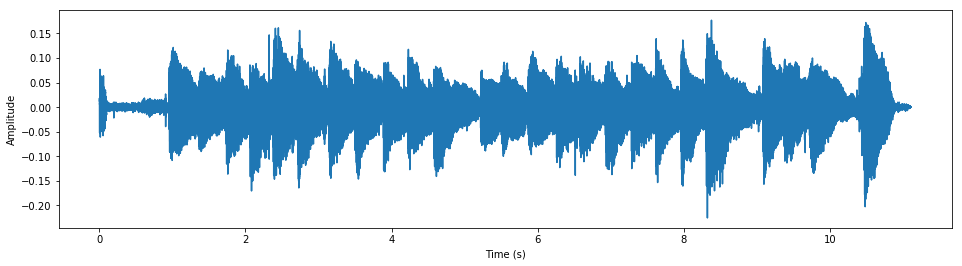

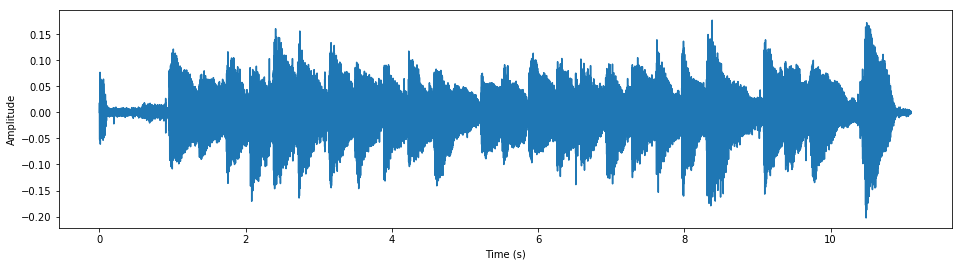

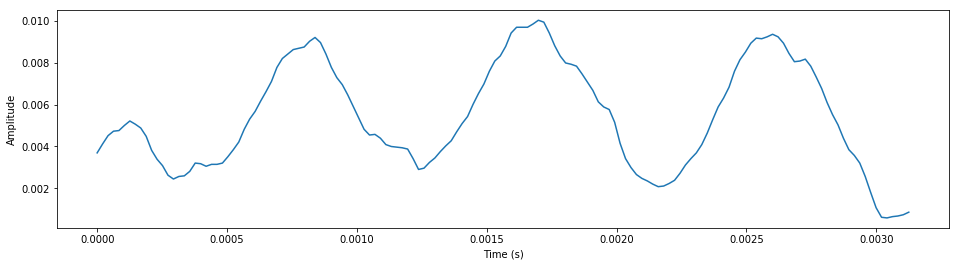

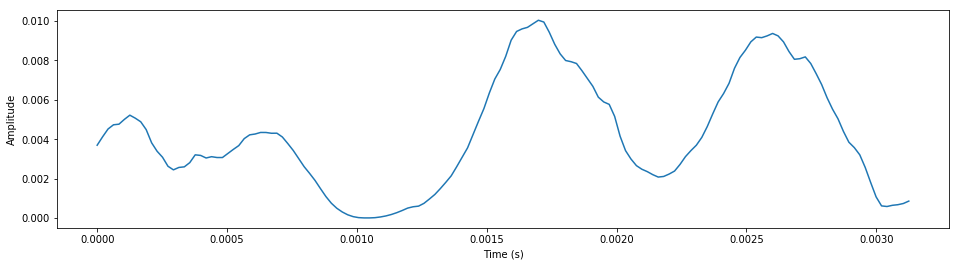

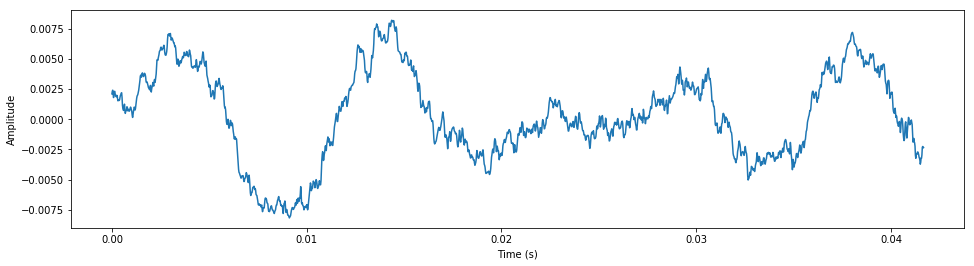

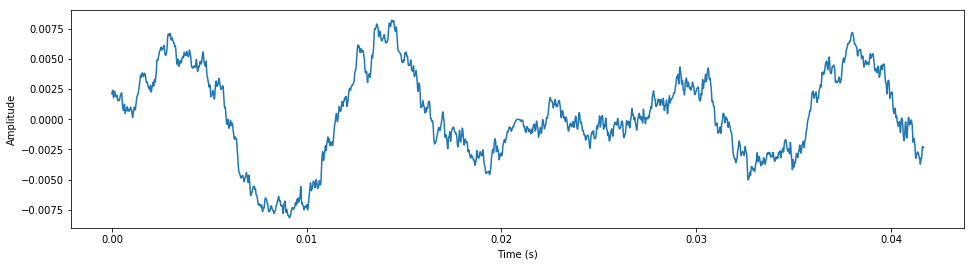

In [26]:
# print(guesses)
sample = []

# print(guesses)

window_size = 1200
for i in range (0, len(source)-window_size, window_size):
#     print(feature_extraction(source[i:window_size], sr))
    sample.append(source[i:i+window_size])
    
signal = []
for i in range(0,len(guesses)):
    max_guess = np.amax(np.abs(sample[guesses[i]]))
    max_target = np.amax(np.abs(target[i*window_size:i*window_size+window_size]))
    signal = np.concatenate([signal,sample[guesses[i]]*max_target/max_guess])

signal = np.array(signal)
signal_smooth = smoothing(signal, window_size, window_type = 'tukey')
#signal = smooth(signal, window_len = 11)
plot_audio(target, sr)
plot_audio(signal_smooth, sr)

plot_audio(signal[10750:10900], sr)
plot_audio(signal_smooth[10750:10900], sr)
plot_audio(signal[23000:25000], sr)
plot_audio(signal_smooth[23000:25000], sr)
# plot_audio(source[23000:25000], sr)
Audio(signal_smooth, rate=sr)
# librosa.output.write_wav('new_target_sourcesmooth.wav', signal, sr)